# MODIS albedo product interpolation  
*J. Michelle Hu  
University of Utah  
September 2024*  
---

How does the original model handle no snow albedo?  

Fill in minimum value when albedo is nan

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyproj
import geopandas as gpd
import xarray as xr
# import hvplot.xarray

from s3fs import S3FileSystem, S3Map

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')
import processing as proc

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/envs/studio/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
%reload_ext autoreload
%autoreload 2

### Env setup

In [3]:
from pathlib import PurePath
# Locate pyproj_datadir for studio env
# From https://stackoverflow.com/questions/69630630/on-fresh-conda-installation-of-pyproj-pyproj-unable-to-set-database-path-pypr
CONDA_ENV = 'studio'
miniconda_dir = '/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3'
proj_version = h.fn_list(miniconda_dir, f'envs/{CONDA_ENV}/conda-meta/proj-[0-9]*.json')[0]

VERSION = PurePath(proj_version).stem

# /uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.4.1-h54d7996_1/share/proj
pyprojdatadir = f'{miniconda_dir}/pkgs/{VERSION}/share/proj'
print(pyprojdatadir)
pyproj.datadir.set_data_dir(pyprojdatadir)

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.4.1-h54d7996_1/share/proj


### Directories and global variables

In [ ]:
MODIS_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/MODIS_albedo_v2023.0e_JMH_reprocessed/'
wy = 2021
albedo_dir = h.fn_list(MODIS_dir, f'*{wy}*')[0]
albedo_dir

In [5]:
# Basin-specific variables
basin = 'littleanimas'

## Load albedo files

In [6]:
albedo_list = h.fn_list(albedo_dir, f'*albedo_{basin}_24.nc')
len(albedo_list)

365

In [7]:
%%time
ds = xr.open_mfdataset(albedo_list, combine='by_coords', chunks='auto')
ds

CPU times: user 7.2 s, sys: 612 ms, total: 7.81 s
Wall time: 13.2 s


<xarray.Dataset> Size: 129MB
Dimensions:              (time: 8760, y: 71, x: 52)
Coordinates:
  * time                 (time) datetime64[ns] 70kB 2020-10-01 ... 2021-09-30...
  * x                    (x) float64 416B 2.512e+05 2.514e+05 ... 2.564e+05
  * y                    (y) float64 568B 4.177e+06 4.177e+06 ... 4.17e+06
Data variables:
    transverse_mercator  (time) |S1 9kB b'' b'' b'' b'' b'' ... b'' b'' b'' b''
    albedo               (time, y, x) float32 129MB dask.array<chunksize=(24, 71, 52), meta=np.ndarray>
Attributes:
    CDI:                 Climate Data Interface version 2.2.1 (https://mpimet...
    Conventions:         CF-1.5
    GDAL:                GDAL 3.5.3, released 2022/10/21
    history:             Thu Aug 29 11:08:01 2024: cdo -O -z zip_4 -f nc4 -s ...
    GDAL_AREA_OR_POINT:  Area
    CDO:                 Climate Data Operators version 2.2.0 (https://mpimet...

In [8]:
%%time
albedo_daily = ds['albedo'].resample(time='1D').mean()
albedo_daily

CPU times: user 2.31 s, sys: 8.55 ms, total: 2.32 s
Wall time: 2.34 s


<xarray.DataArray 'albedo' (time: 365, y: 71, x: 52)> Size: 5MB
dask.array<stack, shape=(365, 71, 52), dtype=float32, chunksize=(1, 71, 52), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 416B 2.512e+05 2.514e+05 ... 2.562e+05 2.564e+05
  * y        (y) float64 568B 4.177e+06 4.177e+06 ... 4.171e+06 4.17e+06
  * time     (time) datetime64[ns] 3kB 2020-10-01 2020-10-02 ... 2021-09-30
Attributes:
    long_name:     GDAL Band Number 1
    grid_mapping:  transverse_mercator

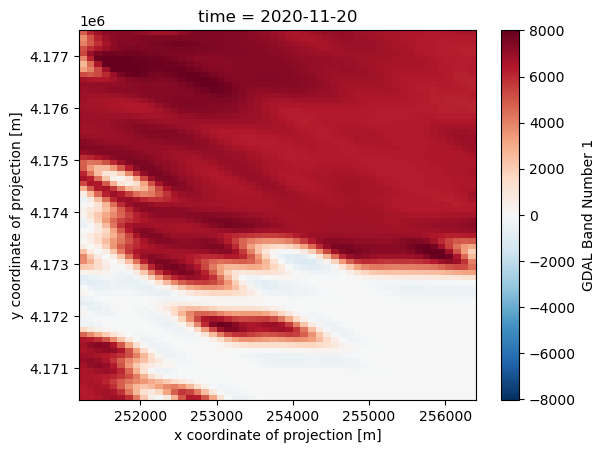

In [9]:
albedo_daily.isel(time=50).plot()

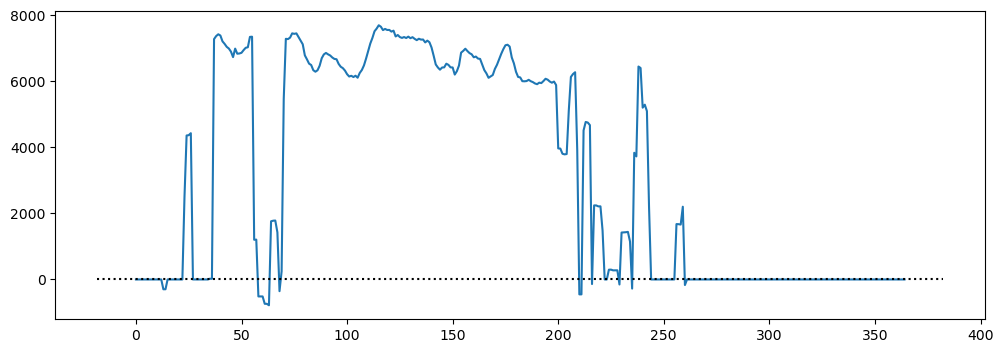

In [10]:
fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(albedo_daily.data[:, 35, 23])
ax.hlines(0, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyles=':', colors='k')

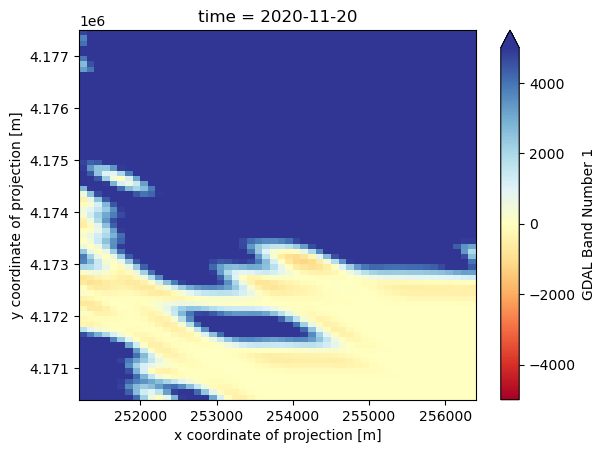

In [11]:
albedo_daily.isel(time=50).plot(vmin=-5000, vmax=5000, cmap='RdYlBu')

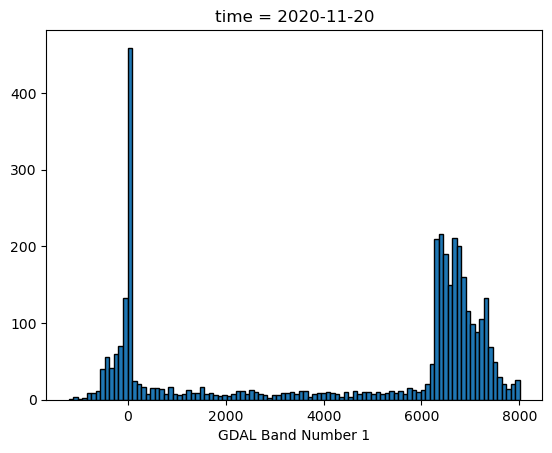

In [12]:
_ = albedo_daily.isel(time=50).plot.hist(bins=100, ec='k')

### Pull in the corresponding original albedo.nc

In [13]:
h.fn_list(albedo_dir, '*20201120*')

['/uufs/chpc.utah.edu/common/home/skiles-group3/MODIS_albedo_v2023.0e_JMH_reprocessed/wy2021/westernUS_Terra_20201120_albedo.tif',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/MODIS_albedo_v2023.0e_JMH_reprocessed/wy2021/westernUS_Terra_20201120_albedo_animas_24.nc',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/MODIS_albedo_v2023.0e_JMH_reprocessed/wy2021/westernUS_Terra_20201120_albedo_animas_AR_24.nc',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/MODIS_albedo_v2023.0e_JMH_reprocessed/wy2021/westernUS_Terra_20201120_albedo_bilinear_littleanimas_jmh_warptest.nc',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/MODIS_albedo_v2023.0e_JMH_reprocessed/wy2021/westernUS_Terra_20201120_albedo_bilinear_tmp.nc',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/MODIS_albedo_v2023.0e_JMH_reprocessed/wy2021/westernUS_Terra_20201120_albedo_bilinear_tmp.vrt',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/MODIS_albedo_v2023.0e_JMH_reprocessed/wy2021/westernUS_Terra_20201120_albedo_cubic_lit

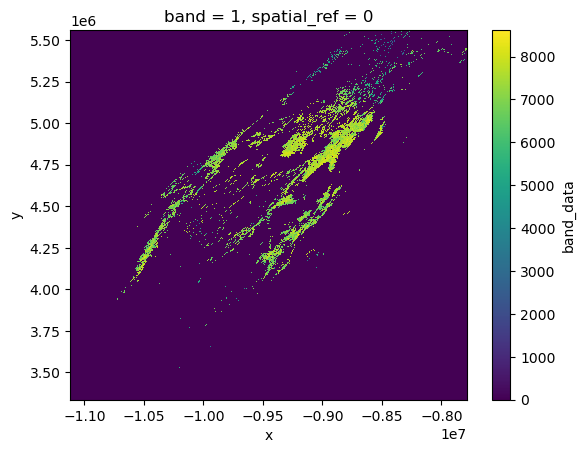

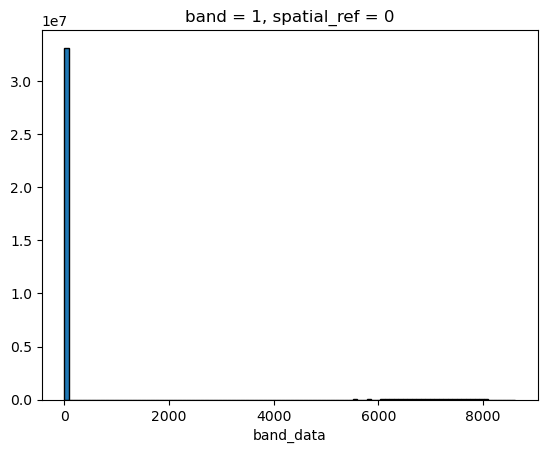

In [14]:
# 2020-11-20
jdx = 0
albedo_nc = np.squeeze(xr.open_mfdataset(h.fn_list(albedo_dir, '*20201120*')[jdx], chunks='auto'))
plt.figure()
albedo_nc['band_data'].plot.imshow()
plt.figure()
_ = albedo_nc['band_data'].plot.hist(bins=100, ec='k')

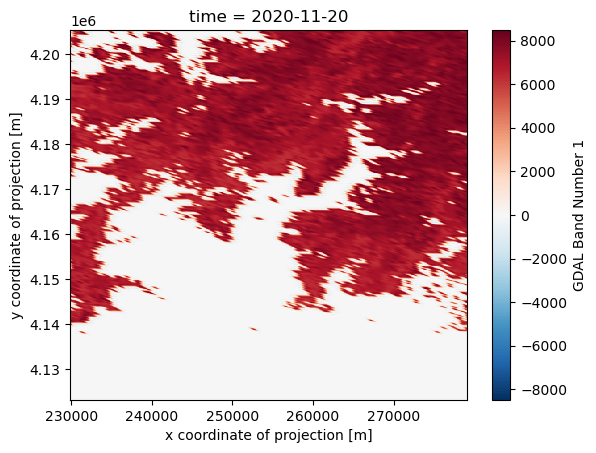

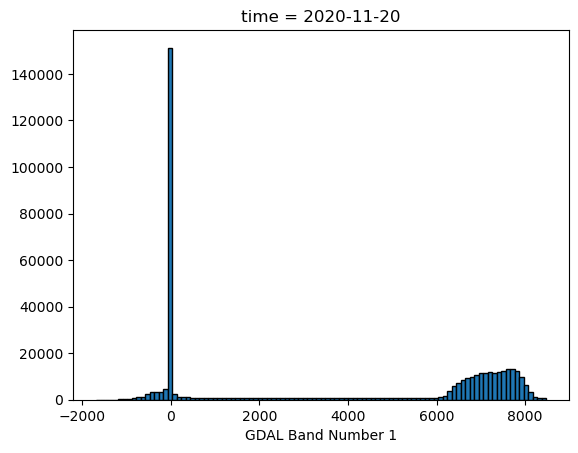

In [15]:
# 2020-11-20
jdx = 1
albedo_nc = xr.open_mfdataset(h.fn_list(albedo_dir, '*20201120*')[jdx], chunks='auto')
# select first time period
albedo_nc = albedo_nc.isel(time=0)
plt.figure()
albedo_nc['albedo'].plot.imshow()
plt.figure()
_ = albedo_nc['albedo'].plot.hist(bins=100, ec='k')

In [16]:
h.fn_list(albedo_dir, '*20201120*little*24.nc')

['/uufs/chpc.utah.edu/common/home/skiles-group3/MODIS_albedo_v2023.0e_JMH_reprocessed/wy2021/westernUS_Terra_20201120_albedo_littleanimas_24.nc',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/MODIS_albedo_v2023.0e_JMH_reprocessed/wy2021/westernUS_Terra_20201120_albedo_littleanimas_AR_24.nc']

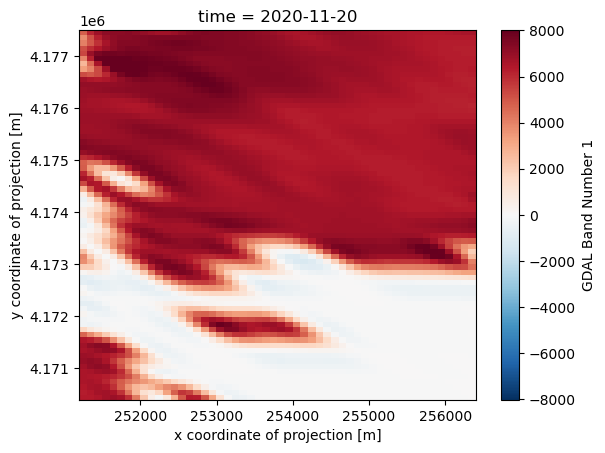

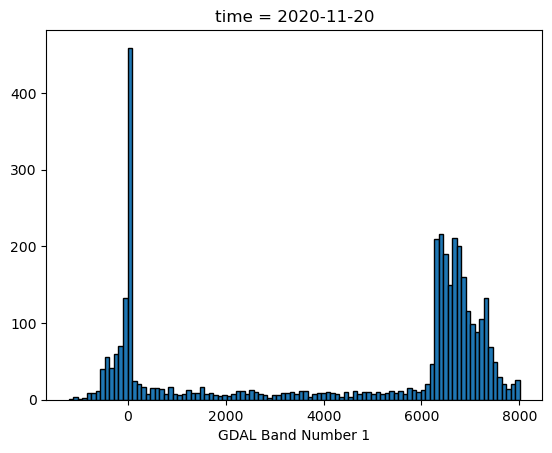

In [17]:
# 2020-11-20
jdx = 0
cubic_nc = xr.open_mfdataset(h.fn_list(albedo_dir, '*20201120*little*24.nc')[jdx], chunks='auto')
# select first time period
cubic_nc = cubic_nc.isel(time=0)
plt.figure()
cubic_nc['albedo'].plot.imshow()
plt.figure()
_ = cubic_nc['albedo'].plot.hist(bins=100, ec='k')

## negative values getting introduced with GDAL warping to basin

# Going to need to handle all values < 0

In [20]:
h.fn_list(albedo_dir, '*20201120*littleanimas*warp*nc')

['/uufs/chpc.utah.edu/common/home/skiles-group3/MODIS_albedo_v2023.0e_JMH_reprocessed/wy2021/westernUS_Terra_20201120_albedo_bilinear_littleanimas_jmh_warptest.nc',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/MODIS_albedo_v2023.0e_JMH_reprocessed/wy2021/westernUS_Terra_20201120_albedo_cubic_littleanimas_jmh_warptest.nc',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/MODIS_albedo_v2023.0e_JMH_reprocessed/wy2021/westernUS_Terra_20201120_albedo_cubicspline_littleanimas_jmh_warptest.nc',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/MODIS_albedo_v2023.0e_JMH_reprocessed/wy2021/westernUS_Terra_20201120_albedo_lanczos_littleanimas_jmh_warptest.nc']

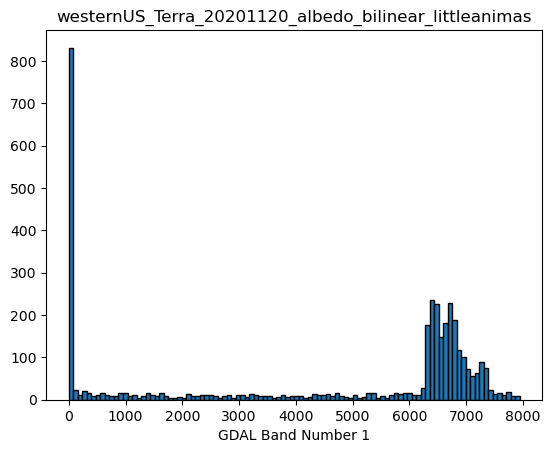

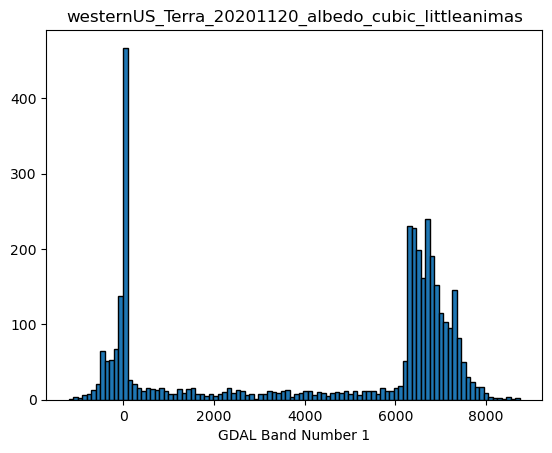

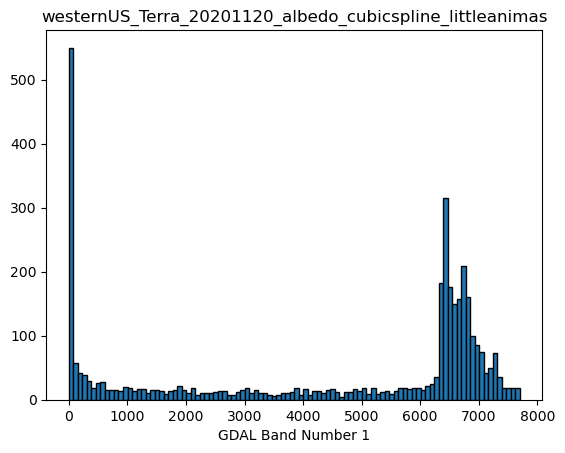

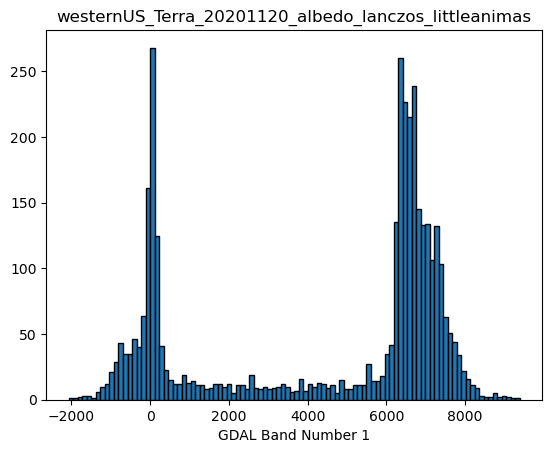

In [23]:
# 2020-11-20
for warp_fn in h.fn_list(albedo_dir, '*20201120*littleanimas*warp*nc'):
    albedo_nc = xr.open_mfdataset(warp_fn, chunks='auto')
    # select first time period
    albedo_nc = albedo_nc.isel(time=0)
    # plt.figure()
    # albedo_nc['albedo'].plot.imshow()
    plt.figure()
    _ = albedo_nc['albedo'].plot.hist(bins=100, ec='k')
    plt.title(PurePath(warp_fn).stem.split('_jmh_warptest')[0]);

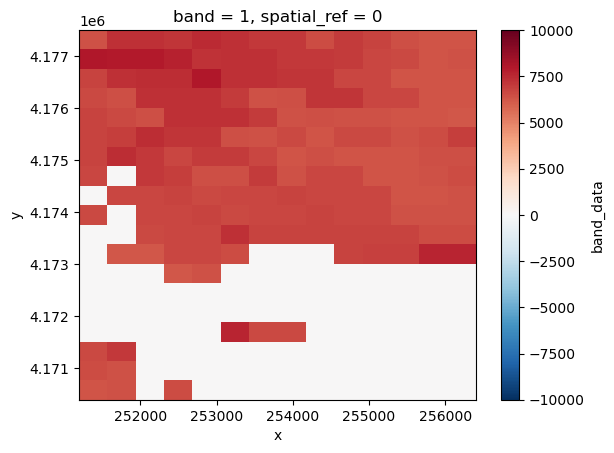

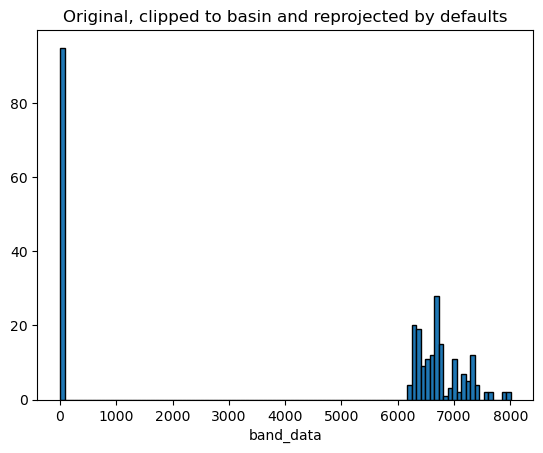

In [24]:
# Plot just the clipped (not resampled to 100 m) version
# gdalwarp -q -overwrite -multi -dstnodata 65535 -te 251200 4170400 256400 4177500 -t_srs EPSG:32613 westernUS_Terra_20201120_albedo.tif westernUS_Terra_20201120_albedo_littleanimas_jmh_warptest_clip.tif
albedo = np.squeeze(xr.open_mfdataset(h.fn_list(albedo_dir, '*20201120*littleanimas*warp*tif')[0], chunks='auto'))
plt.figure()
albedo['band_data'].plot.imshow(cmap='RdBu_r', vmin=-10000, vmax=10000)

plt.figure()
_ = albedo['band_data'].plot.hist(bins=100, ec='k')
plt.title('Original, clipped to basin and reprojected by defaults');

I think this is being introduced by resampling with gdal, check out the resample funcs

## Ok, now read in the cubicspline one (processed using MODIS_albedo_basin.sh)

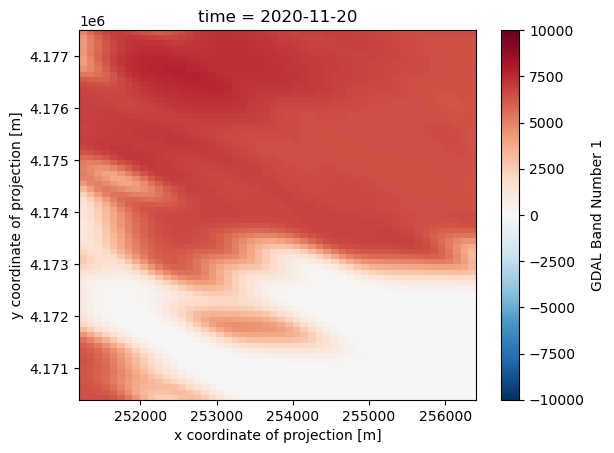

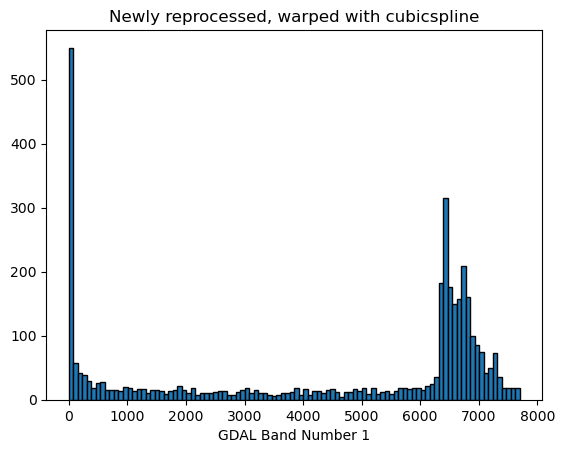

In [26]:
cubicspline_fn = h.fn_list('/uufs/chpc.utah.edu/common/home/skiles-group3/MODIS_albedo_v2023.0e_JMH_reprocessed_cubicspline/wy2021', '*20201120*littleanimas*')[0]
cubicspline_nc = xr.open_mfdataset(cubicspline_fn, chunks='auto')
# select first time period
cubicspline_nc = cubicspline_nc.isel(time=0)

plt.figure()
cubicspline_nc['albedo'].plot.imshow(cmap='RdBu_r', vmin=-10000, vmax=10000)

plt.figure()
_ = cubicspline_nc['albedo'].plot.hist(bins=100, ec='k')
plt.title('Newly reprocessed, warped with cubicspline');

## Compare cubic to cubicspline for littleanimas

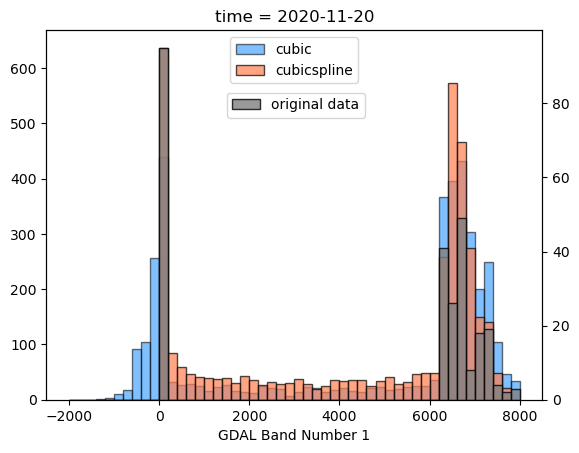

In [27]:
alpha = 0.7
bins = 50
low, high = -2000, 8000
fig, ax = plt.subplots()
ax2 = ax.twinx()
_ = cubic_nc['albedo'].plot.hist(ax=ax, bins=bins, ec='k', alpha=alpha*.8, color='dodgerblue', label='cubic', range=(low, high))
_ = cubicspline_nc['albedo'].plot.hist(ax=ax, bins=bins, ec='k', alpha=alpha, color='coral', label='cubicspline', range=(low, high))
ax.legend()
_ = albedo['band_data'].plot.hist(ax=ax2, bins=bins, ec='k', alpha=0.8, color='gray', label='original data', range=(low, high));
ax2.set_title('')
ax2.legend(bbox_to_anchor=(0.35, 0.85))

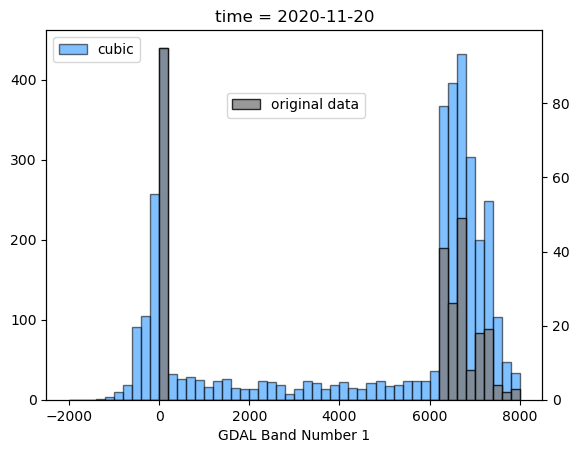

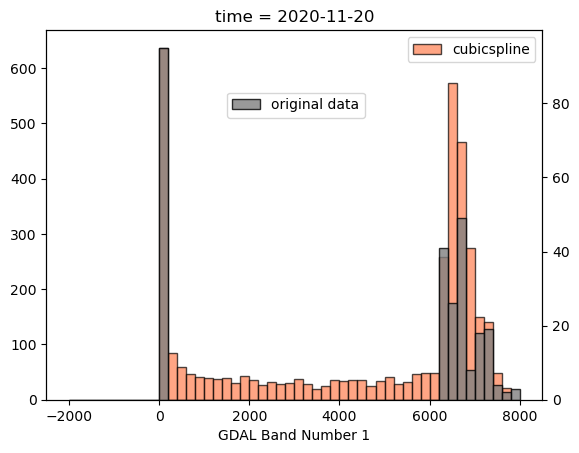

In [28]:
alpha = 0.7
bins = 50
low, high = -2000, 8000
fig, ax = plt.subplots()
ax2 = ax.twinx()
_ = cubic_nc['albedo'].plot.hist(ax=ax, bins=bins, ec='k', alpha=alpha*.8, color='dodgerblue', label='cubic', range=(low, high))
# _ = cubicspline_nc['albedo'].plot.hist(ax=ax, bins=bins, ec='k', alpha=alpha, color='coral', label='cubicspline', range=(low, high))
ax.legend()
_ = albedo['band_data'].plot.hist(ax=ax2, bins=bins, ec='k', alpha=0.8, color='gray', label='original data', range=(low, high));
ax2.set_title('')
ax2.legend(bbox_to_anchor=(0.35, 0.85))

fig, ax = plt.subplots()
ax2 = ax.twinx()
# _ = cubic_nc['albedo'].plot.hist(ax=ax, bins=bins, ec='k', alpha=alpha*.8, color='dodgerblue', label='cubic', range=(low, high))
_ = cubicspline_nc['albedo'].plot.hist(ax=ax, bins=bins, ec='k', alpha=alpha, color='coral', label='cubicspline', range=(low, high))
ax.legend()
_ = albedo['band_data'].plot.hist(ax=ax2, bins=bins, ec='k', alpha=0.8, color='gray', label='original data', range=(low, high));
ax2.set_title('')
ax2.legend(bbox_to_anchor=(0.35, 0.85))

## want to have zeros, preserve original data distribution as much as possible, seems like we should just snap to 0 for the cubic for all values that are negative

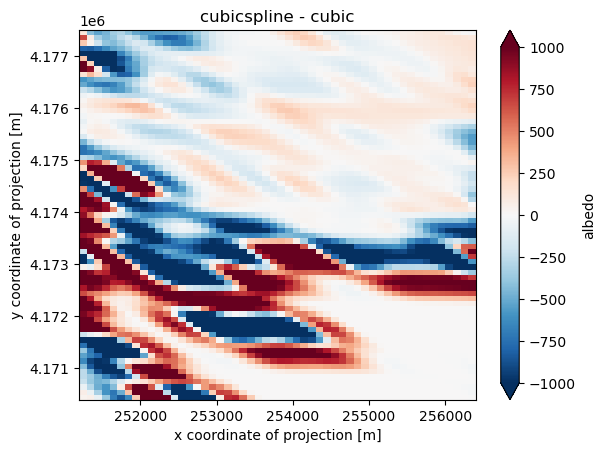

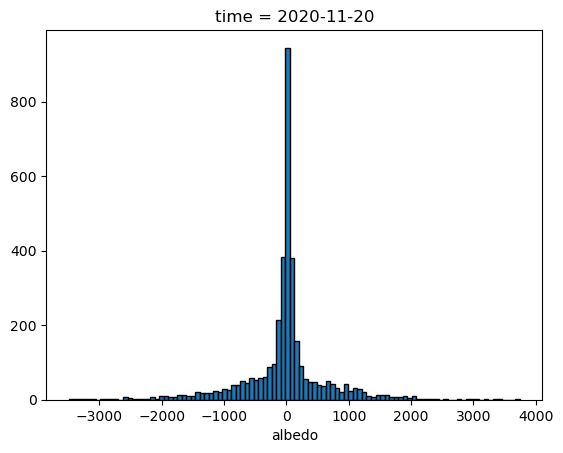

In [29]:
# 2020-11-20
plt.figure()
diff = cubicspline_nc['albedo'] - cubic_nc['albedo']
diff.plot.imshow(vmin=-1000, vmax=1000, cmap='RdBu_r')
plt.title('cubicspline - cubic');
plt.figure()
_ = diff.plot.hist(bins=100, ec='k')

## Ok now read in the test version

In [43]:
import hvplot.xarray

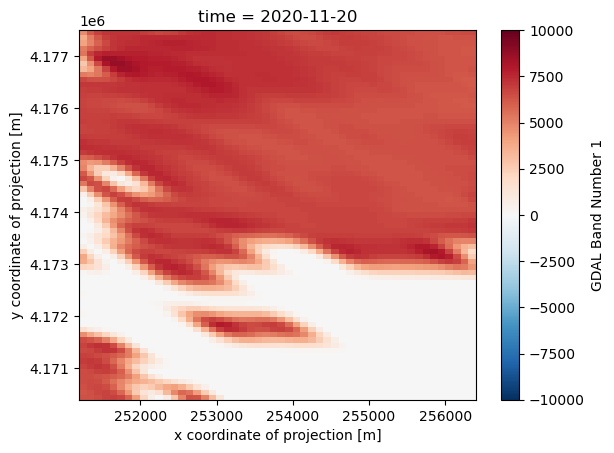

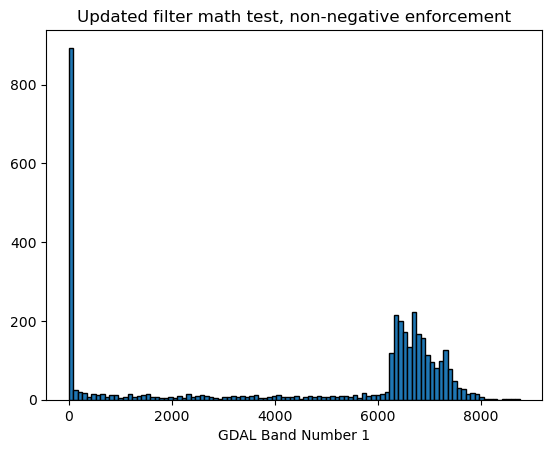

In [55]:
albedo_enforced = np.squeeze(xr.open_mfdataset(h.fn_list(albedo_dir, '*20201120*littleanimas*jmh_24.nc')[0], chunks='auto'))

# select first time period
albedo_enforced = albedo_enforced.isel(time=0)

plt.figure()
albedo_enforced['albedo'].plot.imshow(cmap='RdBu_r', vmin=-10000, vmax=10000)

plt.figure()
_ = albedo_enforced['albedo'].plot.hist(bins=100, ec='k')
plt.title('Updated filter math test, non-negative enforcement');

In [56]:
albedo_enforced['albedo'].hvplot(cmap='RdBu_r', clim=(-10000, 10000), aspect='equal')

:Image   [x,y]   (GDAL Band Number 1)

## Temporal interp: TBD

Need to be able to pull the full year in and fit interpolation to each. Can't just backfill all the zeros...